<a href="https://colab.research.google.com/github/DiploDatos/AnalisisYCuracion/blob/master/Entregable_Parte_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Exploración y Curación de Datos**

*Edición 2021*

----

# Trabajo práctico entregable - parte 1

En esta notebook, vamos a cargar el conjunto de datos de [la compentencia Kaggle](https://www.kaggle.com/dansbecker/melbourne-housing-snapshot) sobre estimación de precios de ventas de propiedades en Melbourne, Australia.

Utilizaremos el conjunto de datos reducido producido por [DanB](https://www.kaggle.com/dansbecker). Hemos subido una copia a un servidor de la Universidad Nacional de Córdoba para facilitar su acceso remoto.

In [1]:
import matplotlib.pyplot as plt
import numpy
import pandas

import seaborn
seaborn.set_context('talk')

In [2]:
import plotly
plotly.__version__
# Make sure it's 4.14.3

'4.14.3'

In [3]:
# To update plotly, uncomment and run the following line:
# !pip install plotly --upgrade

In [4]:
melb_df = pandas.read_csv(
    'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/melb_data.csv')
melb_df[:3]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0


## Ejercicio 1: 

1. Eliminar los valores extremos que no sean relevantes para la predicción de valores de las propiedades.

1. Investigar la distribución de las variables del conjunto de datos y seleccionar un subconjunto de columnas que les parezcan relevantes al problema de predicción del valor de la propiedad.
  1. Justificar cada columna no seleccionada.
  2. Para las variables categóricas seleccionadas, agrupe o combine las categorías poco frecuentes para asegurar que todos los grupos tengan un número mínimo de registros.

2. Agregar información adicional respectiva al entorno de una propiedad a partir del [conjunto de datos de AirBnB](https://www.kaggle.com/tylerx/melbourne-airbnb-open-data?select=cleansed_listings_dec18.csv) utilizado en el práctico. 
  1. Seleccionar qué variables agregar y qué combinaciones aplicar a cada una. Por ejemplo, pueden utilizar solo la columna `price`, o aplicar múltiples transformaciones como la mediana o el mínimo.
  1. Utilizar la variable zipcode para unir los conjuntos de datos. Sólo incluir los zipcodes que tengan una cantidad mínima de registros (a elección) como para que la información agregada sea relevante.
  2. Investigar al menos otras 2 variables que puedan servir para combinar los datos, y justificar si serían adecuadas o no. Pueden asumir que cuentan con la ayuda de anotadores expertos para encontrar equivalencias entre barrios o direcciones, o que cuentan con algoritmos para encontrar las n ubicaciones más cercanas a una propiedad a partir de sus coordenadas geográficas. **NO** es necesario que realicen la implementación.

Pueden leer otras columnas del conjunto de AirBnB además de las que están en `interesting_cols`, si les parecen relevantes.


In [5]:
# data source:
# https://www.kaggle.com/tylerx/melbourne-airbnb-open-data?select=cleansed_listings_dec18.csv
interesting_cols = [
  'description', 'neighborhood_overview',
  'street', 'neighborhood', 'city', 'suburb', 'state', 'zipcode',
  'price', 'weekly_price', 'monthly_price',
  'latitude', 'longitude',
]
airbnb_df = pandas.read_csv(
    'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/cleansed_listings_dec18.csv',
    usecols=interesting_cols)

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (35) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
airbnb_df[:3]

,description,neighborhood_overview,street,neighborhood,city,suburb,state,zipcode,latitude,longitude,price,weekly_price,monthly_price
0,"House: Clean, New, Modern, Quite, Safe. 10Km f...",Very safe! Family oriented. Older age group.,"Bulleen, VIC, Australia",Balwyn North,Manningham,Bulleen,VIC,3105,-37.772684,145.092133,60,NaN,NaN
1,A large air conditioned room with queen spring...,This hip area is a crossroads between two grea...,"Brunswick East, VIC, Australia",Brunswick,Moreland,Brunswick East,VIC,3057,-37.766505,144.980736,35,200.0,803.0
2,RIGHT IN THE HEART OF ST KILDA! It doesn't get...,A stay at our apartment means you can enjoy so...,"St Kilda, VIC, Australia",St Kilda,Port Phillip,St Kilda,VIC,3182,-37.859755,144.977369,159,1253.0,4452.0


In [7]:
airbnb_df.columns

Index(['description', 'neighborhood_overview', 'street', 'neighborhood',
       'city', 'suburb', 'state', 'zipcode', 'latitude', 'longitude', 'price',
       'weekly_price', 'monthly_price'],
      dtype='object')

# 1

Eliminar los valores extremos que no sean relevantes para la predicción de valores de las propiedades

<AxesSubplot:xlabel='Price'>

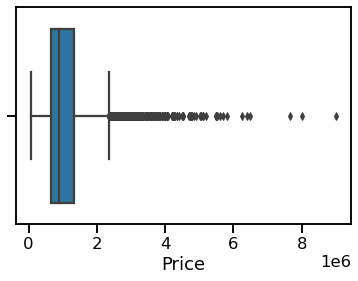

In [8]:
seaborn.boxplot(data=melb_df, x='Price')

<AxesSubplot:xlabel='Propertycount'>

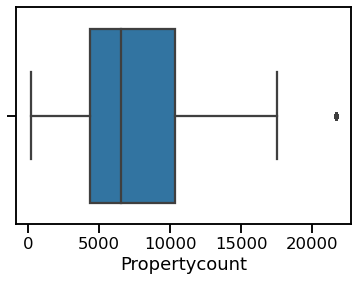

In [9]:
seaborn.boxplot(data=melb_df, x='Propertycount')

<AxesSubplot:xlabel='Rooms'>

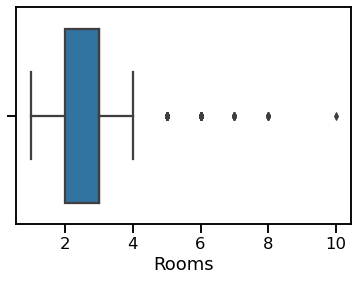

In [10]:
seaborn.boxplot(data=melb_df, x='Rooms')

<AxesSubplot:xlabel='Bathroom'>

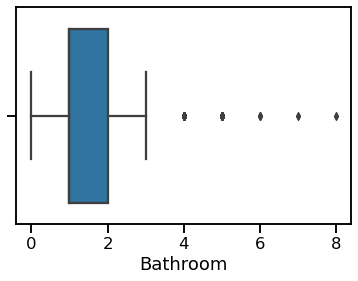

In [11]:
seaborn.boxplot(data=melb_df, x='Bathroom')

<AxesSubplot:xlabel='Car'>

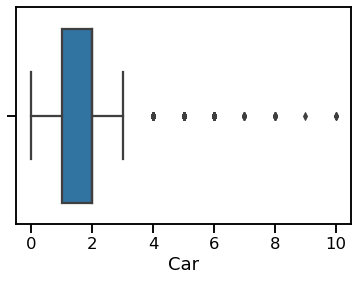

In [12]:
seaborn.boxplot(data=melb_df, x='Car')

In [13]:
def remove_outlier(df_in, col_name, iqr_factor):
    """
  IQR outliers removal (https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/)
  accept a dataframe, remove outliers, return cleaned data in a new dataframe
  see http://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm
  """
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3 - q1  # interquartile range
    fence_low = q1 - iqr_factor * iqr
    fence_high = q3 + iqr_factor * iqr
    df_inliers = df_in.loc[
        (df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)
    ]
    df_outliers = df_in.loc[
        (df_in[col_name] < fence_low) | (df_in[col_name] > fence_high)
    ]
    return df_inliers, df_outliers

In [14]:
iqr_factor = 2.5
df_main_inliers, df_main_outliers = remove_outlier(melb_df, "Price", iqr_factor)
df_main_inliers, df_main_outliers = remove_outlier(df_main_inliers, "Rooms", iqr_factor)
df_main_inliers, df_main_outliers = remove_outlier(df_main_inliers, "Bathroom", iqr_factor)
df_main_inliers, df_main_outliers = remove_outlier(df_main_inliers, "Car", iqr_factor)

display(len(df_main_inliers) / len(melb_df))

0.9632547864506628

<AxesSubplot:xlabel='Rooms'>

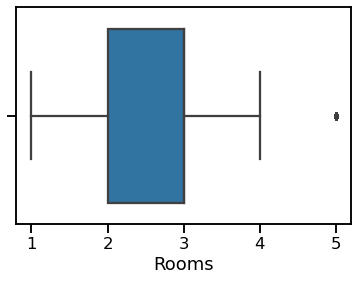

In [15]:
seaborn.boxplot(data=df_main_inliers, x='Rooms')
#fueron removidos los outliers de las variables consideradas

### Exploración

In [16]:
df_main_inliers.describe().round(2)

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,13081.00,13081.00,13081.00,13081.00,13081.00,13081.00,13081.00,13081.00,6846.00,7902.00,13081.00,13081.00,13081.00
mean,2.89,1025077.20,10.15,3104.71,2.87,1.50,1.55,547.27,141.06,1965.17,-37.81,144.99,7453.01
std,0.90,526848.51,5.86,90.35,0.92,0.63,0.85,4045.18,126.96,36.95,0.08,0.10,4390.89
min,1.00,85000.00,0.00,3000.00,0.00,0.00,0.00,0.00,0.00,1196.00,-38.18,144.43,249.00
25%,2.00,640000.00,6.20,3044.00,2.00,1.00,1.00,170.00,92.00,1945.00,-37.86,144.93,4380.00
50%,3.00,890500.00,9.20,3084.00,3.00,1.00,2.00,420.00,124.00,1970.00,-37.80,145.00,6543.00
75%,3.00,1300000.00,13.00,3148.00,3.00,2.00,2.00,646.00,168.00,1999.00,-37.76,145.06,10331.00
max,5.00,3025000.00,47.40,3977.00,20.00,4.00,4.00,433014.00,6791.00,2018.00,-37.41,145.53,21650.00


A simple vista, podemoms notar que en la fila count, hay variables con menos informacion que el resto.

### Reconocimiento de datos faltantes

In [17]:
df_main_inliers.info() # me dice cuantos no-null tengo

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13081 entries, 0 to 13579
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         13081 non-null  object 
 1   Address        13081 non-null  object 
 2   Rooms          13081 non-null  int64  
 3   Type           13081 non-null  object 
 4   Price          13081 non-null  float64
 5   Method         13081 non-null  object 
 6   SellerG        13081 non-null  object 
 7   Date           13081 non-null  object 
 8   Distance       13081 non-null  float64
 9   Postcode       13081 non-null  float64
 10  Bedroom2       13081 non-null  float64
 11  Bathroom       13081 non-null  float64
 12  Car            13081 non-null  float64
 13  Landsize       13081 non-null  float64
 14  BuildingArea   6846 non-null   float64
 15  YearBuilt      7902 non-null   float64
 16  CouncilArea    11836 non-null  object 
 17  Lattitude      13081 non-null  float64
 18  Longti

### Detección las variables con valor cero del dataset

In [18]:
cols = df_main_inliers[df_main_inliers == 0].count(axis=0)
cols[cols > 0]

Distance           6
Bedroom2          16
Bathroom          34
Car             1018
Landsize        1933
BuildingArea      16
dtype: int64

Son estos ceros valores posibles de la variable o datos faltantes codificados asi?

### Posibilidades

 - Distancia al centro es posible que sea cero, ya que puede estar ubicado en el centro
 - Bedroom = pueden ser datos faltantes que por defecto tengan 1 habitacion, o ser monohambientes
 - Bathroom = son datos faltantes, no es posible que no tengan banios. Por defecto puede ser 1 banio
 - Garage = puede darse que no tenga garage o lugar de estacionamiento.
 - Landsize = generalmeente si es un dpto no dice el tamanio del terreno
 - BuildingArea = no puede tener ceros, son datos faltantes.


### Analizando valores nulos en conjunto con variables que tienen valores cero, podemos decir que:

- Distance: tiene 6 datos = 0.
- Bedroom2: tiene 16 datos = 0.
- Bathroom: tiene 34 datos = 0. 
- Car: de total contado 1021 son 0, ademas 62 son nulos.
- Landsize: tiene 1937 datos = 0.
- BuildingArea: del total contado 16 son 0, ademas 6374 son nulos (48% de la informacion)
- YearBuilt; 5308 son nulos. (40% de la informmacion)
- CouncilArea: 1348 son nulos.


### Acciones a implementar

### 1

Reemplazar los datos 0 en Bathroom por 1

In [19]:
import numpy as np
df_main_inliers.loc[df_main_inliers.Bathroom<1,'Bathroom']=1


cols2 = df_main_inliers[df_main_inliers == 0].count(axis=0)#/len(melb_df.index)
cols2[cols2 > 0]

Distance           6
Bedroom2          16
Car             1018
Landsize        1933
BuildingArea      16
dtype: int64

### 2

Sobre la variable CAR, voy a reemplazar los datos nulos con 0

In [20]:
df_main_inliers.fillna({'Car':0}, inplace=True)


df_main_inliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13081 entries, 0 to 13579
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         13081 non-null  object 
 1   Address        13081 non-null  object 
 2   Rooms          13081 non-null  int64  
 3   Type           13081 non-null  object 
 4   Price          13081 non-null  float64
 5   Method         13081 non-null  object 
 6   SellerG        13081 non-null  object 
 7   Date           13081 non-null  object 
 8   Distance       13081 non-null  float64
 9   Postcode       13081 non-null  float64
 10  Bedroom2       13081 non-null  float64
 11  Bathroom       13081 non-null  float64
 12  Car            13081 non-null  float64
 13  Landsize       13081 non-null  float64
 14  BuildingArea   6846 non-null   float64
 15  YearBuilt      7902 non-null   float64
 16  CouncilArea    11836 non-null  object 
 17  Lattitude      13081 non-null  float64
 18  Longti

### 3

Analizamos la variable Bedroom vs Rooms

In [21]:
Bedroom2 = df_main_inliers.Bedroom2
Rooms = df_main_inliers.Rooms
pandas.crosstab(Bedroom2,Rooms)

Rooms,1,2,3,4,5
Bedroom2,,,,,
0.0,0,5,8,3,0
1.0,660,21,5,2,0
2.0,16,3504,158,19,1
3.0,2,72,5524,170,15
4.0,0,8,68,2321,31
5.0,0,1,4,15,443
6.0,0,0,0,0,2
7.0,0,0,0,0,1
8.0,0,0,0,0,1


La variable Rooms es mucho mas informativa que la variable Bedroom2. Por esto decido sacar la variable Bedroom

In [22]:
df_main_inliers.drop(['Bedroom2'], axis=1, inplace=True)

### 4

Considerando que BuildingArea y YearBuilt son relevantes para predecir el precio, decidimos imputar los datos faltantes. 
En el caso de YearBuilt, vamos a completar con KNN.


In [23]:
missing_values_count = df_main_inliers.isna().sum()
missing_values_count

Suburb              0
Address             0
Rooms               0
Type                0
Price               0
Method              0
SellerG             0
Date                0
Distance            0
Postcode            0
Bathroom            0
Car                 0
Landsize            0
BuildingArea     6235
YearBuilt        5179
CouncilArea      1245
Lattitude           0
Longtitude          0
Regionname          0
Propertycount       0
dtype: int64

<AxesSubplot:>

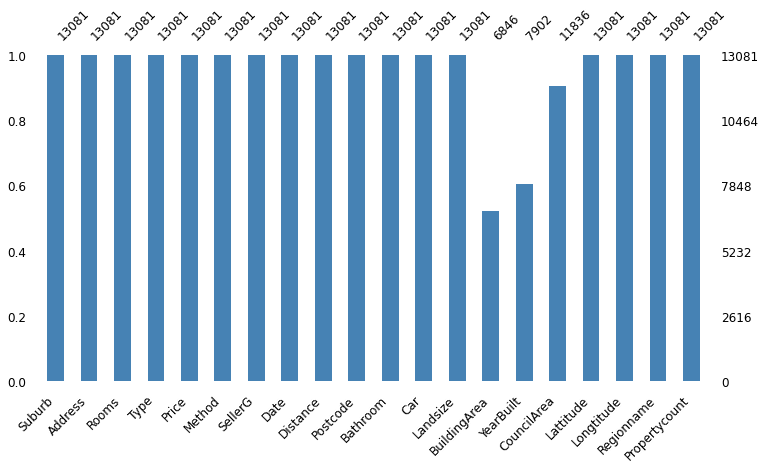

In [24]:
import missingno as msno
msno.bar(df_main_inliers,figsize=(12, 6), fontsize=12, color='steelblue')

<AxesSubplot:>

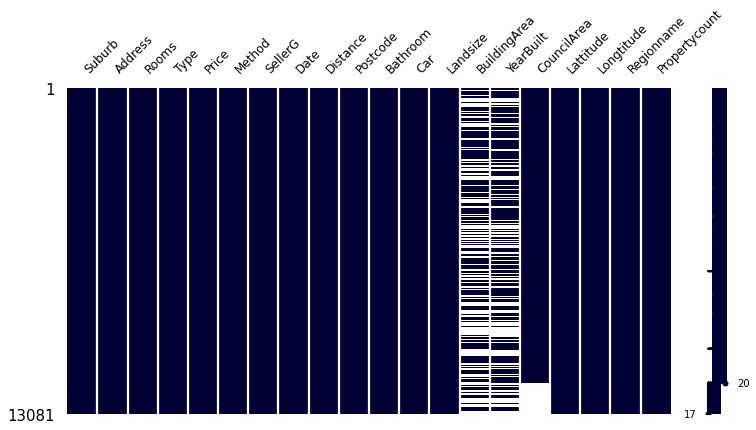

In [25]:
msno.matrix(df_main_inliers,figsize=(12, 6), fontsize=12, color=[0,0,0.2])

In [26]:
#borramos las dos variables
df_main_inliers=df_main_inliers.drop(['BuildingArea'], axis=1)
df_main_inliers=df_main_inliers.drop(['YearBuilt'], axis=1)

df_main_inliers

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bathroom,Car,Landsize,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,1.0,1.0,202.0,Yarra,-37.79960,144.99840,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,1.0,0.0,156.0,Yarra,-37.80790,144.99340,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,2.0,0.0,134.0,Yarra,-37.80930,144.99440,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,2.0,1.0,94.0,Yarra,-37.79690,144.99690,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,1.0,2.0,120.0,Yarra,-37.80720,144.99410,Northern Metropolitan,4019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13574,Westmeadows,9 Black St,3,h,582000.0,S,Red,26/08/2017,16.5,3049.0,2.0,2.0,256.0,NaN,-37.67917,144.89390,Northern Metropolitan,2474.0
13575,Wheelers Hill,12 Strada Cr,4,h,1245000.0,S,Barry,26/08/2017,16.7,3150.0,2.0,2.0,652.0,NaN,-37.90562,145.16761,South-Eastern Metropolitan,7392.0
13576,Williamstown,77 Merrett Dr,3,h,1031000.0,SP,Williams,26/08/2017,6.8,3016.0,2.0,2.0,333.0,NaN,-37.85927,144.87904,Western Metropolitan,6380.0
13577,Williamstown,83 Power St,3,h,1170000.0,S,Raine,26/08/2017,6.8,3016.0,2.0,4.0,436.0,NaN,-37.85274,144.88738,Western Metropolitan,6380.0


# 2

Investigar la distribución de las variables del conjunto de datos y seleccionar un subconjunto de columnas que les parezcan relevantes al problema de predicción del valor de la propiedad.

In [27]:
columnas_numericas = df_main_inliers.select_dtypes(['int', 'float']).columns

### Gráfico de probabilidad:
Cuanto más se parezca nuestra gráfica a una línea de 45 grados, más normal será.

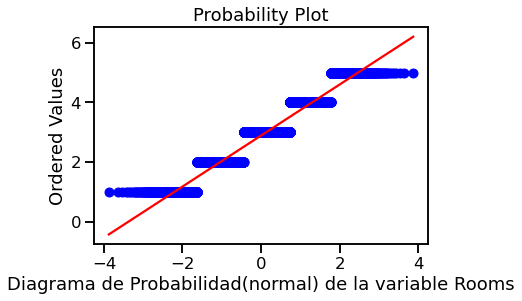

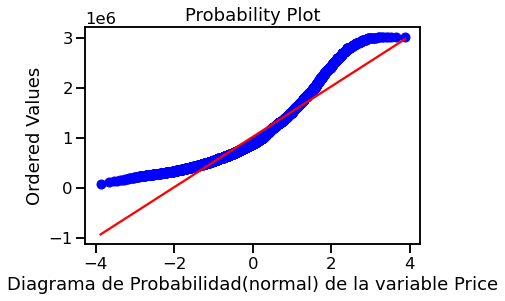

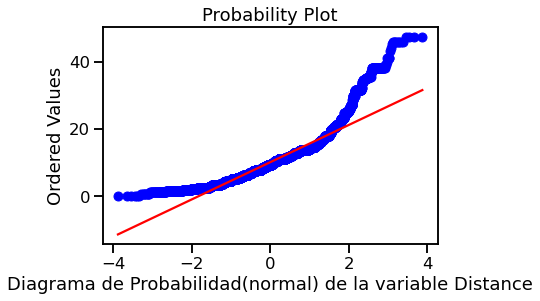

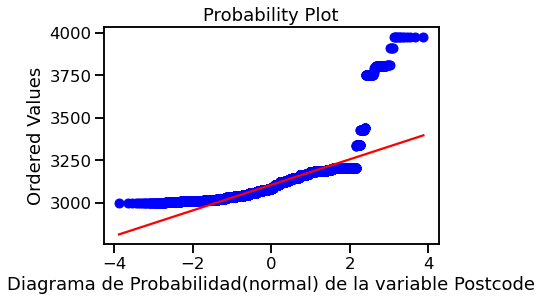

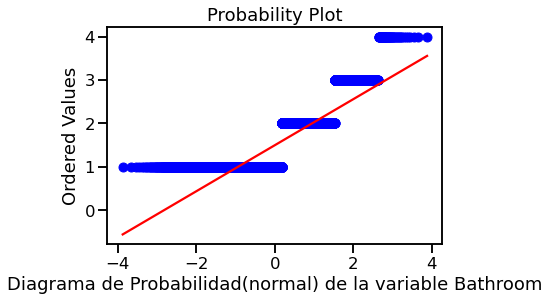

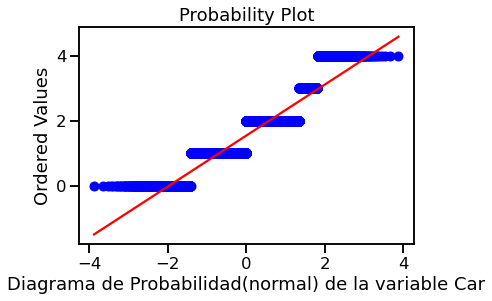

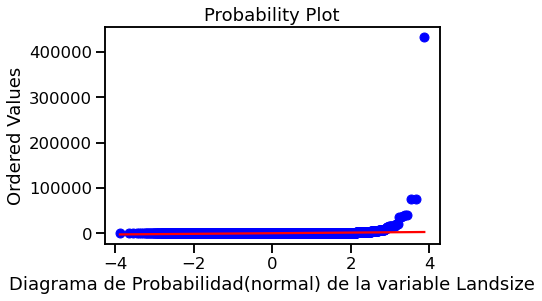

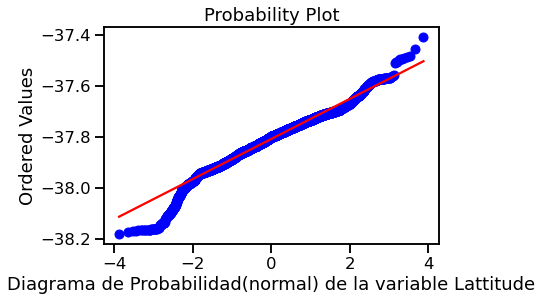

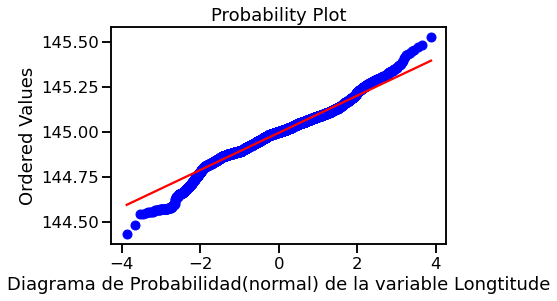

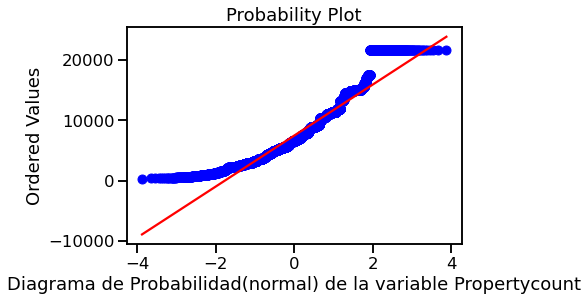

In [28]:
from scipy import stats
def normalidad_variable_numerica(col):
    stats.probplot(df_main_inliers[col], plot=plt)
    plt.xlabel('Diagrama de Probabilidad(normal) de la variable {}'.format(col))
    plt.show()

    
for num_col in columnas_numericas:
    normalidad_variable_numerica(num_col)

### Test de normalidad: 
aceptamos o rechazamos que una variable sigue una distribución normal, para, en el caso de un nivel de confianza de 95%, el pval sea menor o mayor a 0.05.



In [29]:
for num_col in columnas_numericas:
    _, pval = stats.normaltest(df_main_inliers[num_col])
    if(pval < 0.05):
        print("Columna {} no sigue una distribución normal".format(num_col))
        

Columna Rooms no sigue una distribución normal
Columna Price no sigue una distribución normal
Columna Distance no sigue una distribución normal
Columna Postcode no sigue una distribución normal
Columna Bathroom no sigue una distribución normal
Columna Car no sigue una distribución normal
Columna Landsize no sigue una distribución normal
Columna Lattitude no sigue una distribución normal
Columna Longtitude no sigue una distribución normal
Columna Propertycount no sigue una distribución normal


### Histogramas:
Podemos crear un histograma para ver la distribución de una variable.

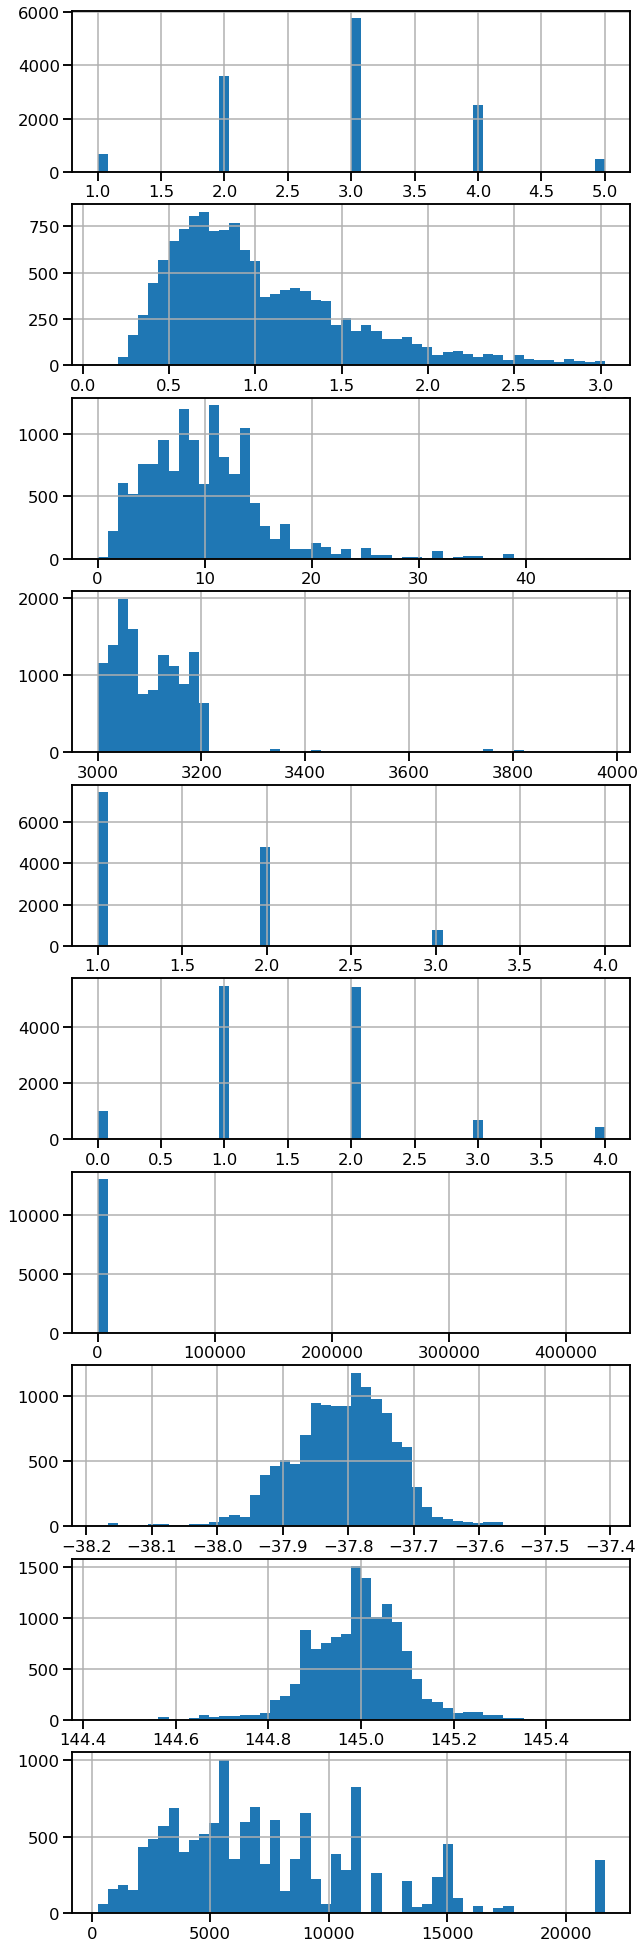

In [30]:
fig, axs = plt.subplots(len(columnas_numericas), figsize=(10, 35))
for n, col in enumerate(columnas_numericas):
    df_main_inliers[col].hist(ax=axs[n],bins=50)
    #ver de agregar titulo a los graficos
    

In [31]:
df_main_inliers.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bathroom', 'Car', 'Landsize',
       'CouncilArea', 'Lattitude', 'Longtitude', 'Regionname',
       'Propertycount'],
      dtype='object')

In [32]:
selected_columns = ['Suburb', 'Rooms', 'Type','Price','Distance', 'Postcode', 'Bathroom', 'Car', 'Landsize',
        'CouncilArea','Propertycount']

df_filtered = df_main_inliers[selected_columns]

### Columnas no seleccionadas

- Address, Method, SeleerG, Date, Lattitude, Longitude, Regionname,  : se descartan porque considero que no aportan informacion relevante


## 4

Para las variables categóricas seleccionadas, agrupe o combine las categorías poco frecuentes para asegurar que todos los grupos tengan un número mínimo de registros


In [33]:
df_filtered.Suburb.value_counts().tail(61)

Kurunjang             4
Wyndham Vale          4
Knoxfield             4
Seaholme              4
Aspendale Gardens     4
                     ..
Plumpton              1
Sandhurst             1
Hurstbridge           1
Beaconsfield Upper    1
Attwood               1
Name: Suburb, Length: 61, dtype: int64

In [34]:
#agrupo todos las categorias que tengan una frecuencia menor a 5
suburb_replace=df_filtered.Suburb.value_counts().tail(61).index.tolist()
df_filtered.replace(to_replace=suburb_replace, value='others', inplace=True)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [35]:
df_filtered.Suburb.value_counts()

Reservoir         348
Richmond          256
Bentleigh East    246
Preston           235
Brunswick         219
                 ... 
Derrimut            5
Warrandyte          5
Kings Park          5
Lower Plenty        5
Hallam              5
Name: Suburb, Length: 253, dtype: int64

In [36]:
df_filtered['Type'].value_counts()

h    8958
u    3011
t    1112
Name: Type, dtype: int64

In [37]:
df_filtered.Postcode.value_counts()

3073.0    348
3020.0    292
3121.0    287
3040.0    279
3046.0    278
         ... 
3793.0      1
3427.0      1
3765.0      1
3099.0      1
3809.0      1
Name: Postcode, Length: 197, dtype: int64

In [38]:
df_filtered.CouncilArea.value_counts()
#mismo analisis para esta variable

Moreland             1148
Boroondara           1060
Moonee Valley         975
Darebin               917
Glen Eira             841
Maribyrnong           679
Stonnington           677
Yarra                 639
Port Phillip          613
Banyule               588
Melbourne             466
Bayside               452
Hobsons Bay           419
Brimbank              405
Monash                324
Manningham            304
Whitehorse            291
Kingston              203
others                165
Hume                  157
Wyndham                86
Maroondah              79
Knox                   78
Melton                 63
Frankston              51
Greater Dandenong      50
Casey                  36
Nillumbik              35
Yarra Ranges           18
Cardinia                8
Macedon Ranges          7
Unavailable             1
Moorabool               1
Name: CouncilArea, dtype: int64

In [39]:
#agrupo todos las categorias que tengan una frecuencia menor a 20
councilarea_replace=df_filtered.CouncilArea.value_counts().tail(5).index.tolist()
df_filtered.replace(to_replace=councilarea_replace, value='Other',inplace=True)
councilarea_replace
#remplazo por other

['Yarra Ranges', 'Cardinia', 'Macedon Ranges', 'Unavailable', 'Moorabool']

In [40]:
df_filtered.CouncilArea.value_counts()

Moreland             1148
Boroondara           1060
Moonee Valley         975
Darebin               917
Glen Eira             841
Maribyrnong           679
Stonnington           677
Yarra                 639
Port Phillip          613
Banyule               588
Melbourne             466
Bayside               452
Hobsons Bay           419
Brimbank              405
Monash                324
Manningham            304
Whitehorse            291
Kingston              203
others                165
Hume                  157
Wyndham                86
Maroondah              79
Knox                   78
Melton                 63
Frankston              51
Greater Dandenong      50
Casey                  36
Other                  35
Nillumbik              35
Name: CouncilArea, dtype: int64

In [41]:
df_filtered.columns

Index(['Suburb', 'Rooms', 'Type', 'Price', 'Distance', 'Postcode', 'Bathroom',
       'Car', 'Landsize', 'CouncilArea', 'Propertycount'],
      dtype='object')

## 5

Agregar información adicional respectiva al entorno de una propiedad a partir del conjunto de datos de AirBnB utilizado en el práctico. 

## 6

Seleccionar qué variables agregar y qué combinaciones aplicar a cada una. Por ejemplo, pueden utilizar solo la columna price, o aplicar múltiples transformaciones como la mediana o el mínimo.

## 7

Utilizar la variable zipcode para unir los conjuntos de datos. Sólo incluir los zipcodes que tengan una cantidad mínima de registros (a elección) como para que la información agregada sea relevante.

In [42]:
airbnb_df.columns

Index(['description', 'neighborhood_overview', 'street', 'neighborhood',
       'city', 'suburb', 'state', 'zipcode', 'latitude', 'longitude', 'price',
       'weekly_price', 'monthly_price'],
      dtype='object')

In [43]:
airbnb_df.zipcode.value_counts()[:5]

3000.0    2491
3000       876
3006.0     860
3182.0     579
3182       556
Name: zipcode, dtype: int64

In [44]:
airbnb_df['zipcode'] = pandas.to_numeric(airbnb_df.zipcode, errors='coerce')

In [45]:
airbnb_df.zipcode.value_counts()

3000.0    3367
3006.0    1268
3182.0    1135
3141.0     881
3004.0     728
          ... 
4068.0       1
3200.0       1
5791.0       1
7266.0       1
2134.0       1
Name: zipcode, Length: 247, dtype: int64

Antes de unir los conjuntos de datos, tenemos que asegurarnos de que tengamos suficientes registros en común como para agregar información relevantes.

In [46]:
intersection = numpy.intersect1d(
    airbnb_df.zipcode.values, df_filtered.Postcode.values, assume_unique=False)
print("Airbnb unique zipcodes", len(airbnb_df.zipcode.unique()))
print("Sales unique zipcodes", len(df_filtered.Postcode.unique()))
print("Common zipcodes", len(intersection))

# interseccion de conjuntos

Airbnb unique zipcodes 248
Sales unique zipcodes 197
Common zipcodes 191


In [47]:
print('Records in Sales df with corresponding zipcode form Sales df',
      df_filtered.Postcode.isin(intersection).sum() / len(df_filtered))
print('Records in Airbnb df with corresponding zipcode form Airbnb df',
      airbnb_df.zipcode.isin(intersection).sum() / len(airbnb_df))

Records in Sales df with corresponding zipcode form Sales df 0.9986239584129654
Records in Airbnb df with corresponding zipcode form Airbnb df 0.9302904564315353


In [48]:
columns_airbnb = ['zipcode', 'price']

airbnb_filtered = airbnb_df[columns_airbnb]


In [49]:
# airbnb_2 = airbnb_filtered.groupby('zipcode').mean().reset_index()[:5]

airbnb_2 = airbnb_filtered[columns_airbnb].groupby('zipcode')\
   .agg(airbnb_record_count=('price', 'count'),
    airbnb_price_day_mean=('price', 'mean'))\
   .reset_index()

In [50]:
merged_sales_df = df_filtered.merge(
    airbnb_2, how='left',
    left_on='Postcode', right_on='zipcode'
)
merged_sales_df

,Suburb,Rooms,Type,Price,Distance,Postcode,Bathroom,Car,Landsize,CouncilArea,Propertycount,zipcode,airbnb_record_count,airbnb_price_day_mean
0,Abbotsford,2,h,1480000.0,2.5,3067.0,1.0,1.0,202.0,Yarra,4019.0,3067.0,258.0,130.624031
1,Abbotsford,2,h,1035000.0,2.5,3067.0,1.0,0.0,156.0,Yarra,4019.0,3067.0,258.0,130.624031
2,Abbotsford,3,h,1465000.0,2.5,3067.0,2.0,0.0,134.0,Yarra,4019.0,3067.0,258.0,130.624031
3,Abbotsford,3,h,850000.0,2.5,3067.0,2.0,1.0,94.0,Yarra,4019.0,3067.0,258.0,130.624031
4,Abbotsford,4,h,1600000.0,2.5,3067.0,1.0,2.0,120.0,Yarra,4019.0,3067.0,258.0,130.624031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13076,Westmeadows,3,h,582000.0,16.5,3049.0,2.0,2.0,256.0,NaN,2474.0,3049.0,21.0,92.285714
13077,Wheelers Hill,4,h,1245000.0,16.7,3150.0,2.0,2.0,652.0,NaN,7392.0,3150.0,189.0,124.026455
13078,Williamstown,3,h,1031000.0,6.8,3016.0,2.0,2.0,333.0,NaN,6380.0,3016.0,74.0,191.094595
13079,Williamstown,3,h,1170000.0,6.8,3016.0,2.0,4.0,436.0,NaN,6380.0,3016.0,74.0,191.094595


## 8

Investigar al menos otras 2 variables que puedan servir para combinar los datos, y justificar si serían adecuadas o no. Pueden asumir que cuentan con la ayuda de anotadores expertos para encontrar equivalencias entre barrios o direcciones, o que cuentan con algoritmos para encontrar las n ubicaciones más cercanas a una propiedad a partir de sus coordenadas geográficas. NO es necesario que realicen la implementación.

In [51]:
#genero un array de los valores en formato str
array=df_filtered.Suburb.values
array_str_df=[]
for i in array:
    array_str_df.append(str(i))
array2=airbnb_df.suburb.values
array_str_airbnb=[]
for i in array2:
    array_str_airbnb.append(str(i))
    
#realizo la interseccion de arrays en formato str
import collections
def flatten(x):
    result = []
    for el in x:
        if isinstance(x, collections.Iterable) and not isinstance(el, str):
            result.extend(flatten(el))
        else:
            result.append(el)
    return result
 
a = flatten(array_str_airbnb)
b = flatten(array_str_df)
common_elements = list(set(a).intersection(set(b)))


print("Airbnb unique suburb", len(airbnb_df.suburb.unique()))
print("Sales unique suburb", len(df_filtered.Suburb.unique()))
print("Common suburb", len(common_elements))
#se ve que la mayoria de los valores de sales estan en el de airbnb

Airbnb unique suburb 543
Sales unique suburb 253
Common suburb 246


<ipython-input-51-94c0f0698cff>:16: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  if isinstance(x, collections.Iterable) and not isinstance(el, str):


In [52]:

#genero un array de los valores en formato str
array=df_filtered.Suburb.values
array_str_df=[]
for i in array:
    array_str_df.append(str(i))
array2=airbnb_df.neighborhood.values
array_str_airbnb=[]
for i in array2:
    array_str_airbnb.append(str(i))
    
#realizo la interseccion de arrays en formato str
import collections
def flatten(x):
    result = []
    for el in x:
        if isinstance(x, collections.Iterable) and not isinstance(el, str):
            result.extend(flatten(el))
        else:
            result.append(el)
    return result
 
a = flatten(array_str_airbnb)
b = flatten(array_str_df)
common_elements = list(set(a).intersection(set(b)))


print("Airbnb unique neighborhood", len(airbnb_df.neighborhood.unique()))
print("Sales unique suburb", len(df_filtered.Suburb.unique()))
print("Common suburb", len(common_elements))
#se ve que la mayoria de los valores de sales estan en el de airbnb

Airbnb unique neighborhood 60
Sales unique suburb 253
Common suburb 50


Analizamos las dos variables que se podrian utilizar para realizar la union, de las cuales observamos que las variables suburb y neighborhood del dataframe airbnb podria utilizarse para realizar el merge con la variable suburb de melb_df. 
Podriamos utilizar un join para unir los valores de neighboorhood con suburb para que incluya todos los valores de suburb y no solo los comunes.

## Ejercicio 2: Imputación

1. Imputar los valores faltantes de la columna CouncilArea en base a la información presente en Suburb. (Si en el punto anterior no seleccionó ninguna de estas variables, agréguelas ahora el conjunto de datos).

2. Imputar los valores faltantes de la(s) columna(s) que se agregaron a partir del conjunto de datos de AirBnB.



In [53]:
missing_values_count = merged_sales_df['CouncilArea'].isna().sum() 
missing_values_count

1245

In [54]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
import re
# Get dummies
dummies_variables = merged_sales_df[['CouncilArea','Suburb','Type']]
df_dummies = pandas.get_dummies(dummies_variables, drop_first=True,dummy_na=True)
df = pandas.concat([merged_sales_df,df_dummies],axis=1)

df=df.drop(["CouncilArea"],axis=1)
df=df.drop(["Suburb"],axis=1)
df=df.drop(["Type"],axis=1)

nan_df = df.loc[:, df.columns.str.endswith("_nan")]
pattern = "^([^_]*)_"
regex = re.compile(pattern)

for index in df.index:
    for col_nan in nan_df.columns:
        if df.loc[index,col_nan] == 1:
            col_id = regex.search(col_nan).group(1)
            targets = df.columns[df.columns.str.startswith(col_id+'_')]
            df.loc[index, targets] = np.nan
            
df.drop(df.columns[df.columns.str.endswith('_nan')], axis=1, inplace=True)
df

,Rooms,Price,Distance,Postcode,Bathroom,Car,Landsize,Propertycount,zipcode,airbnb_record_count,...,Suburb_Wheelers Hill,Suburb_Williamstown,Suburb_Williamstown North,Suburb_Windsor,Suburb_Wollert,Suburb_Yallambie,Suburb_Yarraville,Suburb_others,Type_t,Type_u
0,2,1480000.0,2.5,3067.0,1.0,1.0,202.0,4019.0,3067.0,258.0,...,0,0,0,0,0,0,0,0,0,0
1,2,1035000.0,2.5,3067.0,1.0,0.0,156.0,4019.0,3067.0,258.0,...,0,0,0,0,0,0,0,0,0,0
2,3,1465000.0,2.5,3067.0,2.0,0.0,134.0,4019.0,3067.0,258.0,...,0,0,0,0,0,0,0,0,0,0
3,3,850000.0,2.5,3067.0,2.0,1.0,94.0,4019.0,3067.0,258.0,...,0,0,0,0,0,0,0,0,0,0
4,4,1600000.0,2.5,3067.0,1.0,2.0,120.0,4019.0,3067.0,258.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13076,3,582000.0,16.5,3049.0,2.0,2.0,256.0,2474.0,3049.0,21.0,...,0,0,0,0,0,0,0,0,0,0
13077,4,1245000.0,16.7,3150.0,2.0,2.0,652.0,7392.0,3150.0,189.0,...,1,0,0,0,0,0,0,0,0,0
13078,3,1031000.0,6.8,3016.0,2.0,2.0,333.0,6380.0,3016.0,74.0,...,0,1,0,0,0,0,0,0,0,0
13079,3,1170000.0,6.8,3016.0,2.0,4.0,436.0,6380.0,3016.0,74.0,...,0,1,0,0,0,0,0,0,0,0


In [55]:
from sklearn.impute import KNNImputer
import re

# Get CouncilArea & Suburb dummies
dummies_variables = merged_sales_df[['CouncilArea','Suburb']]
df_dummies = pandas.get_dummies(dummies_variables, drop_first=True,dummy_na=True)

nan_df = df_dummies.loc[:, df_dummies.columns.str.endswith("_nan")]
pattern = "^([^_]*)_"
regex = re.compile(pattern)

for index in df_dummies.index:
    for col_nan in nan_df.columns:
        if df_dummies.loc[index,col_nan] == 1:
            col_id = regex.search(col_nan).group(1)
            targets = df_dummies.columns[df_dummies.columns.str.startswith(col_id+'_')]
            df_dummies.loc[index, targets] = np.nan
            
df_dummies.drop(df_dummies.columns[df_dummies.columns.str.endswith('_nan')], axis=1, inplace=True)

# Inputing by suburb
imputer = KNNImputer(n_neighbors=5)
df_dummies = pandas.DataFrame(imputer.fit_transform(df_dummies),columns = df_dummies.columns)

# Concat new dummies vars and drop unused columns
df = pandas.concat([merged_sales_df,df_dummies],axis=1)
df=df.drop(["CouncilArea"],axis=1)
df=df.drop(["Suburb"],axis=1)

In [59]:
df.isna().any().head(60)

Rooms                            False
Type                             False
Price                            False
Distance                         False
Postcode                         False
Bathroom                         False
Car                              False
Landsize                         False
Propertycount                    False
zipcode                           True
airbnb_record_count               True
airbnb_price_day_mean             True
CouncilArea_Bayside              False
CouncilArea_Boroondara           False
CouncilArea_Brimbank             False
CouncilArea_Casey                False
CouncilArea_Darebin              False
CouncilArea_Frankston            False
CouncilArea_Glen Eira            False
CouncilArea_Greater Dandenong    False
CouncilArea_Hobsons Bay          False
CouncilArea_Hume                 False
CouncilArea_Kingston             False
CouncilArea_Knox                 False
CouncilArea_Manningham           False
CouncilArea_Maribyrnong  

In [60]:
from sklearn.preprocessing import MinMaxScaler

# Get dummies for Type
new_dummies_variables = df[['Type']]
new_df_dummies = pandas.get_dummies(new_dummies_variables, drop_first=True,dummy_na=True)

## Concat type dummies
new_df = pandas.concat([df,new_df_dummies],axis=1)
new_df = new_df.drop(['Type'],)

# Scalling
scaler = MinMaxScaler()
new_df = pandas.DataFrame(scaler.fit_transform(new_df), columns = new_df.columns)

# Inputing rest of the missing values
imputer = KNNImputer(n_neighbors=5)
new_df = pandas.DataFrame(imputer.fit_transform(new_df),columns = new_df.columns)
new_df

ValueError: could not convert string to float: 'h'

In [ ]:
new_df.isna().any().head(60)

In [ ]:
new_df[np.isnan(df).any(axis=1)]

## Ejercicio 3

Crear y guardar un nuevo conjunto de datos con todas las transformaciones realizadas anteriormente.

In [ ]:
new_df.to_csv('Dataframe_melb.csv',index=False)

In [ ]:
new_df=pandas.read_csv("Dataframe_melb.csv")
new_df